<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Import Libraries</p>

In [ ]:
#!pip install progressbar2

In [ ]:
#!pip install contextlib2

In [ ]:
#!pip install shapely

In [1]:
#Clone Git Repository
#!git clone https://github.com/fizyr/keras-retinanet.git
%cd C:/Users/Gianlu/keras-retinanet/
#!python setup.py build_ext --inplace

C:\Users\Gianlu\keras-retinanet


In [2]:
%cd C:/Users/Gianlu/keras-retinanet/

C:\Users\Gianlu\keras-retinanet


**IMPORT LIBRARIES**

In [3]:
import pandas as pd
# show images inline
%matplotlib inline

import keras
import tensorflow as tf

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import ast

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet import models

# import libraries to download weights
import keras_resnet
import urllib.request

# libraries to transform data
import contextlib2
import io
import IPython
import json
import pathlib
import sys

# libraries for Confusion Matrix
from shapely.geometry import Polygon,Point
import shapely
import gc

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Connect to the weights from the last training</p>

Weights from last training

In [4]:
PRETRAINED_MODEL = './snapshots/resnet50_csv_10.h5'

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Load Data </p>

In [5]:
def bbox_to_dict(row):
    dictionary= dict({'x_min': ast.literal_eval(row['bbox'])[0],
                  'y_min': ast.literal_eval(row['bbox'])[1],
                  'x_max': ast.literal_eval(row['bbox'])[2],
                  'y_max': ast.literal_eval(row['bbox'])[3]}
                  )
    return dictionary

def concat_name_row(row):
    concatenation=row['img_name']+str(row['Unnamed: 0'])
    return concatenation


In [10]:
df_test = pd.read_csv("D:/Pictures/dataset/new_images/valid.csv")

df_test=df_test.loc[df_test["class"].astype(str) != '']
#df_test['img_name'] = df_test['img_name'].apply(eval)

df_test['image_path'] = "D:/Pictures/dataset/new_images/test/" + df_test['img_name'].astype(str) 
df_extrain=df_test.explode('img_name') # Single annotation per row
df_extrain['annotations']=df_extrain.apply(lambda row: bbox_to_dict(row), axis=1)
df_extrain['img_id']=df_extrain.apply(lambda row: concat_name_row(row), axis=1)
df_extrain.reset_index(inplace=True)
df_extrain.head()

,index,Unnamed: 0,img_name,class,bbox,bbox_count,object_count,stratify_group,fold,image_path,annotations,img_id
0,0,0,BloodImage_00377.jpg,RBC,"['448', '244', '566', '350']",16.0,3.0,3_1,0.0,D:/Pictures/dataset/new_images/test/BloodImage...,"{'x_min': '448', 'y_min': '244', 'x_max': '566...",BloodImage_00377.jpg0
1,1,1,BloodImage_00377.jpg,RBC,"['238', '215', '333', '310']",16.0,3.0,3_1,0.0,D:/Pictures/dataset/new_images/test/BloodImage...,"{'x_min': '238', 'y_min': '215', 'x_max': '333...",BloodImage_00377.jpg1
2,2,2,BloodImage_00377.jpg,RBC,"['15', '280', '103', '406']",16.0,3.0,3_1,0.0,D:/Pictures/dataset/new_images/test/BloodImage...,"{'x_min': '15', 'y_min': '280', 'x_max': '103'...",BloodImage_00377.jpg2
3,3,3,BloodImage_00377.jpg,RBC,"['239', '70', '353', '167']",16.0,3.0,3_1,0.0,D:/Pictures/dataset/new_images/test/BloodImage...,"{'x_min': '239', 'y_min': '70', 'x_max': '353'...",BloodImage_00377.jpg3
4,4,4,BloodImage_00377.jpg,RBC,"['467', '13', '590', '126']",16.0,3.0,3_1,0.0,D:/Pictures/dataset/new_images/test/BloodImage...,"{'x_min': '467', 'y_min': '13', 'x_max': '590'...",BloodImage_00377.jpg4


In [11]:
df_extrain_main=pd.DataFrame(pd.json_normalize(df_extrain['annotations']), columns=['x_min', 'y_min', 'x_max', 'y_max']).join(df_extrain)
df_extrain_main=df_extrain_main[df_extrain_main['class'].notna()]
df_extrain_main=df_extrain_main[['image_path','x_min', 'y_min', 'x_max', 'y_max','class','img_name','img_id']] 
df_extrain_main.head(10)

,image_path,x_min,y_min,x_max,y_max,class,img_name,img_id
0,D:/Pictures/dataset/new_images/test/BloodImage...,448,244,566,350,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg0
1,D:/Pictures/dataset/new_images/test/BloodImage...,238,215,333,310,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg1
2,D:/Pictures/dataset/new_images/test/BloodImage...,15,280,103,406,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg2
3,D:/Pictures/dataset/new_images/test/BloodImage...,239,70,353,167,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg3
4,D:/Pictures/dataset/new_images/test/BloodImage...,467,13,590,126,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg4
5,D:/Pictures/dataset/new_images/test/BloodImage...,412,130,520,236,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg5
7,D:/Pictures/dataset/new_images/test/BloodImage...,355,385,474,480,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg7
8,D:/Pictures/dataset/new_images/test/BloodImage...,340,259,442,359,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg8
9,D:/Pictures/dataset/new_images/test/BloodImage...,174,138,274,233,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg9
10,D:/Pictures/dataset/new_images/test/BloodImage...,98,47,196,164,RBC,BloodImage_00377.jpg,BloodImage_00377.jpg10


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Transfoming Data Format </p>

In [12]:
def create_tf_example(rowss,data_df):
    """Create a tf.Example entry for a given training image."""
    full_path = os.path.join(rowss.image_path)
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')

    height = image.size[1] # Image height
    width = image.size[0] # Image width
    #print(width,height)
    filename = f'{rowss.img_id}'.encode('utf8') # Unique id of the image.
    encoded_image_data = None # Encoded image bytes
    image_format = 'jpeg'.encode('utf8') # b'jpeg' or b'png'

    xmins = [] 
    xmaxs = [] 
    ymins = [] 
    ymaxs = [] 
    
    # Convert ---> [xmin,ymin,width,height] to [xmins,xmaxs,ymins,ymaxs]
    xmin = rowss['x_min']
    xmax = rowss['x_max']
    ymin = rowss['y_min']
    ymax = rowss['y_max']
    

    #main_data.append((rowss['image_path'],xmins,xmaxs,ymins,ymaxs))
    return rowss['image_path'],xmin,ymin,xmax,ymax

In [13]:
tf_example1=[]

from PIL import Image, ImageDraw
for index, row in df_extrain_main.iterrows():
            if index % 1000 == 0:
                print('Processed {0} images.'.format(index))
            image_path,xmins,ymins,xmaxs,ymaxs=create_tf_example(row,df_extrain_main)
            #print(image_path,xmins,xmaxs,ymins,ymaxs)
            df_extrain_main.loc[index,'image_path']=image_path
            df_extrain_main.loc[index,'x_min']=xmins
            df_extrain_main.loc[index,'y_min']=ymins
            df_extrain_main.loc[index,'x_max']=xmaxs
            df_extrain_main.loc[index,'y_max']=ymaxs


Processed 0 images.


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Creating CSV for Validation </p>

In [14]:
classes=pd.DataFrame([{'class':'Platelets','label':0},{'class':'WBC','label':1},{'class':'RBC','label':2},{'class':'FBC','label':3}])
classes.to_csv("D:/Pictures/dataset/new_images/classes.csv",index=False,header=False)  # This CSV will be use in training

df_extrain_main['class']!=''
df_extrain_main[['image_path','x_min','y_min','x_max','y_max','class']].to_csv("D:/Pictures/dataset/new_images/annotation_validation.csv",index=False,header=False)

### Scrit to evaluate the model

In [26]:
#SCRIPT TO EVALUATE MODEL
!C:/Users/Gianlu/keras-retinanet/keras_retinanet/bin/evaluate.py --convert-model csv D:/Pictures/dataset/new_images/annotation.csv D:/Pictures/dataset/new_images/classes.csv {PRETRAINED_MODEL}

Loading model, this may take a second...
431 instances of class Platelets with average precision: 0.7763
425 instances of class WBC with average precision: 0.9775
4244 instances of class RBC with average precision: 0.7326
1 instances of class FBC with average precision: 0.0000
Inference time for 412 images: 1.0214
mAP using the weighted average of precisions among classes: 0.7565
mAP: 0.6216


2022-10-11 14:23:59.121328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-10-11 14:23:59.121366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 14:24:03.180519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-10-11 14:24:03.181686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-10-11 14:24:03.182825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-10-11 14:24:03.183962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Load Trained Model</p>

In [16]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0]) 
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv("D:/Pictures/dataset/new_images/classes.csv",header=None).T.loc[0].to_dict()

snapshots\resnet50_csv_10.h5


<a id="1"></a>
# <p style="background-color:#000000;font-family:newtimeroman;color:#fff;font-size:120%;text-align:center;border-radius:20px 80px;">Predicted vs Actual</p>

In [17]:
THRES_SCORE = 0.4  # Set Score Threshold Value

def class_to_color(class_id):
    colors = {'Platelets':(255,0,0),'WBC':(0,255,0),'RBC':(0,0,255),'FBC':(255,255,0)}
    return colors[class_id]

def df_plot_orinal(drawOG,img_path,df):
    df=df[df['image_path']==img_path]
    for i,r in df.iterrows():
        cv2.rectangle(drawOG, (int(r['x_min']), int(r['y_min'])), (int(r['x_max']), int(r['y_max'])), (255,0,0),2)
    

def img_inference(img_path):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  df_plot_orinal(drawOG,img_path,df_extrain_main)
  # correct for image scale
  boxes /= scale
  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      #print(score)
      if score < THRES_SCORE:
          continue
      color = label_color(label)
      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}%".format(labels_to_names[label], score*100) #
      draw_caption(draw, b, caption)
    
  fig = plt.figure(figsize=(20, 20))
  ax1=fig.add_subplot(1, 2, 1)
  plt.imshow(draw)
  ax2=fig.add_subplot(1, 2, 2)
  plt.imshow(drawOG)

  ax1.title.set_text('Predicted')
  ax2.title.set_text('Actual')
  plt.show()

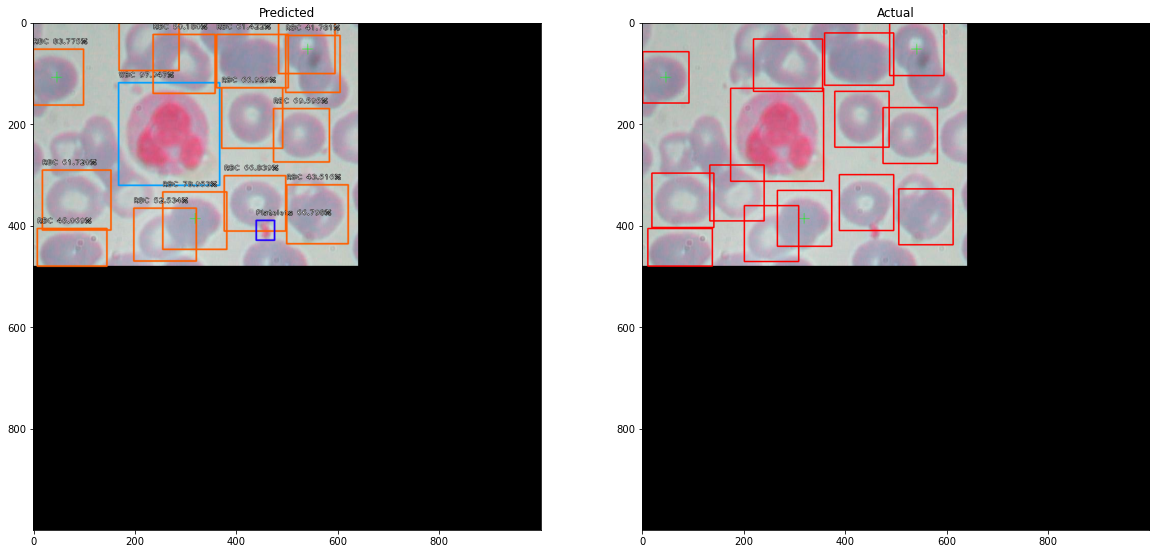

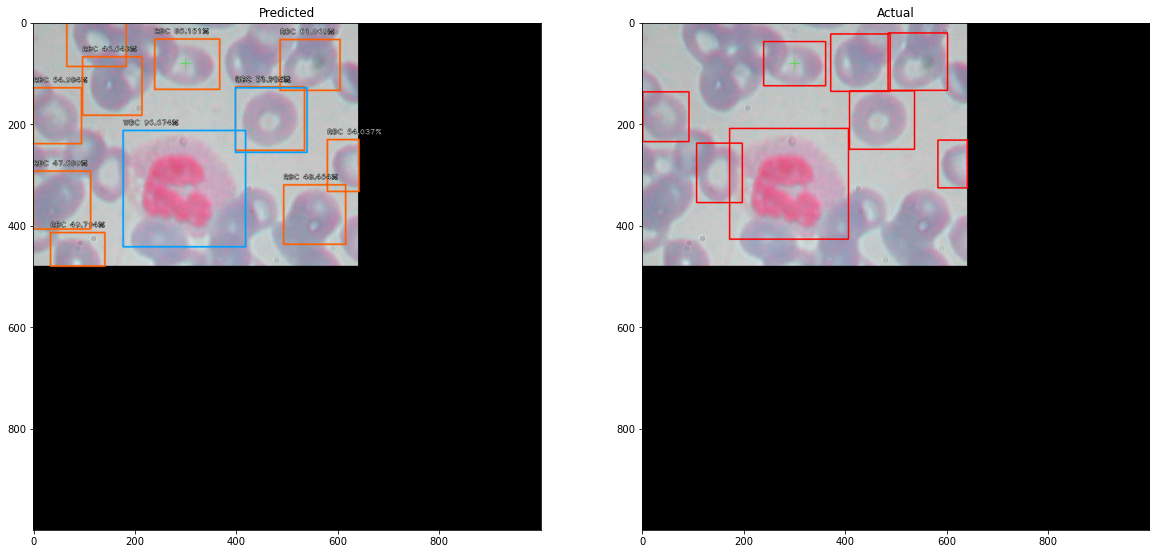

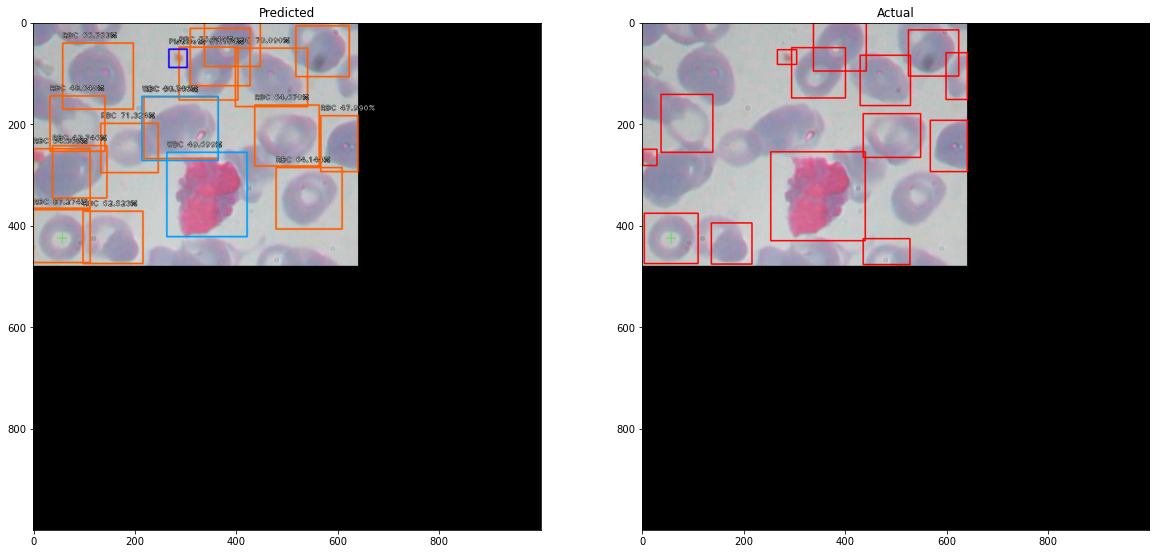

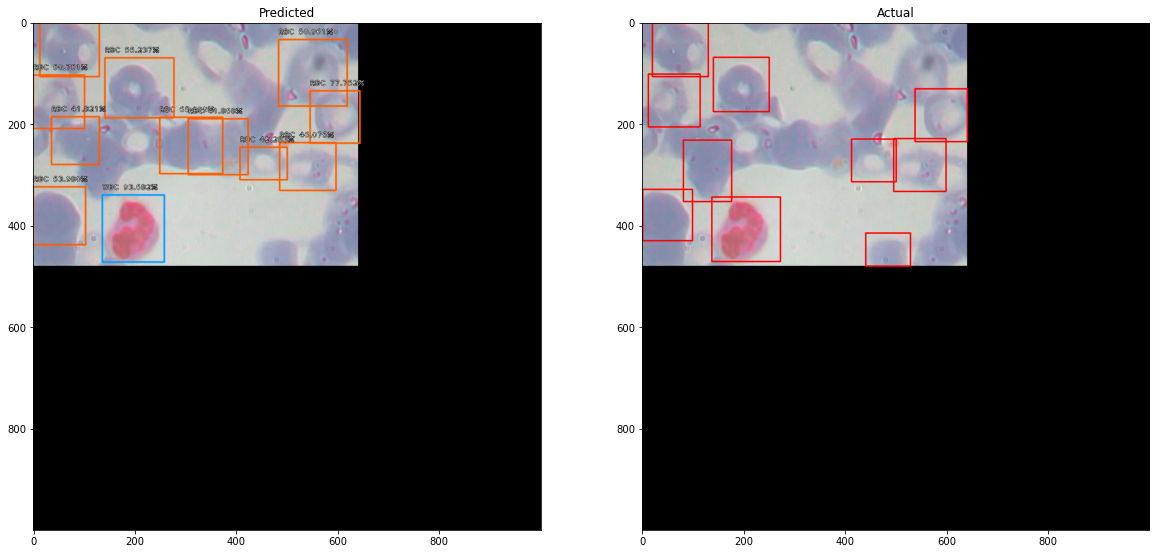

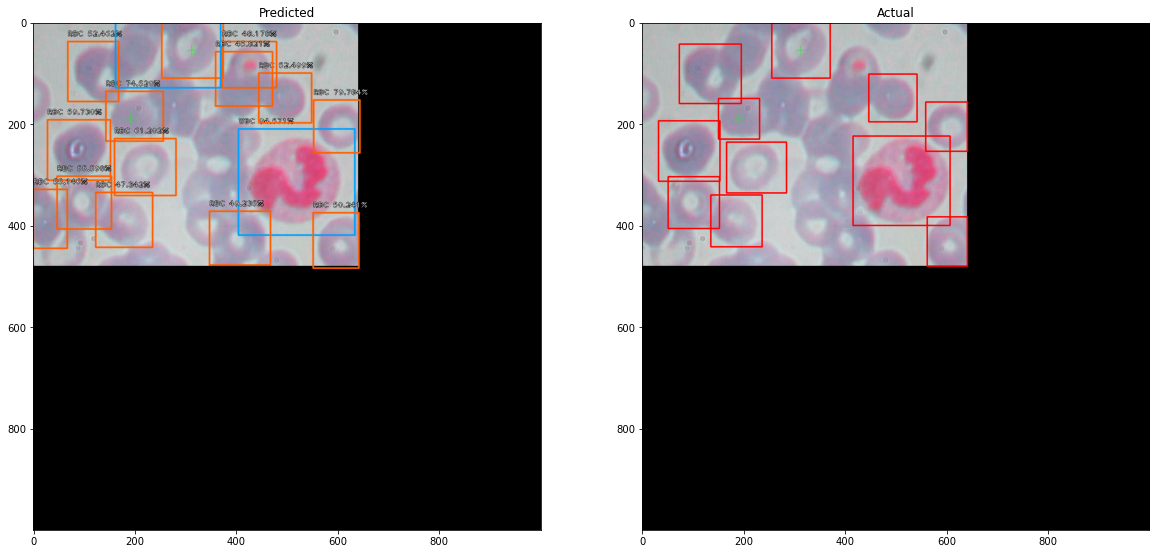

In [18]:
data=df_extrain_main.sample(n=5)  #Predict on Random 5 Image
for i,r in data.iterrows():
    img_inference(r['image_path'])